In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#% pip install torch===1.7.1 torchvision===0.8.2 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
#% pip install tqdm scikit-learn tensorboard pandas pyaml torchlibrosa
%apt install -y libsndfile1

UsageError: Line magic function `%apt` not found.


In [ ]:
%cd Project-Acoustic-Scene-Classification-DCASE-Final

[Errno 2] No such file or directory: 'Project-Acoustic-Scene-Classification-DCASE-Final'
/content/drive/.shortcut-targets-by-id/1LU4hupdEeS2P7GrBnEit-cTXA28tHCMc/Project-Acoustic-Scene-Classification-DCASE-Final


In [ ]:
%ls

configs/                 our_trained_models/  README.md   test.py
construct_dataset.ipynb  projectAli.ipynb     saves/      trained_models/
data/                    projet2.ipynb        saves_Ali/  train.py
Dockerfile               projet.ipynb         setup.py    utils.py
LICENSE                  __pycache__/         sp4asc/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time
import torchaudio
from sp4asc.datasets.dcase import DCaseDataset
import librosa
import librosa.display
import pandas as pd

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sp4asc.models.cnns import LogMelSpectrogram
from sp4asc.training import TrainingManager

EPS = 1e-6
import utils
import copy
%matplotlib inline

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


### Creating ResNet model

In [ ]:
model_resnet = models.resnet18(pretrained=False,progress=True)

In [ ]:
model_resnet.fc = torch.nn.Linear(in_features=512,out_features=10)
model_resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

In [ ]:
print(model_resnet)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Data Extraction

In [ ]:
def get_audio(file):
    signal, sample_rate = librosa.load(file, sr= 22050) 

def draw_signal(signal, sample_rate):
    FIG_SIZE = (15,4)
    plt.figure(figsize=FIG_SIZE)
    librosa.display.waveshow(signal, sample_rate, alpha=0.4)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Waveform")

    # FFT -> power spectrum
    # perform Fourier transform
    fft = np.fft.fft(signal)

    # calculate abs values on complex numbers to get magnitude
    spectrum = np.abs(fft)

    # create frequency variable
    f = np.linspace(0, sample_rate, len(spectrum))

    # take half of the spectrum and frequency
    left_spectrum = spectrum[:int(len(spectrum)/2)]
    left_f = f[:int(len(spectrum)/2)]

    # plot spectrum
    plt.figure(figsize=FIG_SIZE)
    plt.plot(left_f, left_spectrum, alpha=0.4)
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.title("Power spectrum")


In [ ]:
%ls

configs/                 our_trained_models/  README.md   test.py
construct_dataset.ipynb  projectAli.ipynb     saves/      trained_models/
data/                    projet2.ipynb        saves_Ali/  train.py
Dockerfile               projet.ipynb         setup.py    utils.py
LICENSE                  __pycache__/         sp4asc/


In [ ]:
import os

root_dir = "data/TAU-urban-acoustic-scenes-2020-mobile-development"

files = os.listdir(root_dir + '/audio_train')

files = [[file] + file.replace('.wav','').split('-',5) for file in files]
df_files = pd.DataFrame(files,columns=['file_name','label_name','city','location_id','segment_id','device_id'])
df_files.to_csv(root_dir + '/train_data.csv',index=False)

PermissionError: ignored

In [ ]:
root_dir ="data/TAU-urban-acoustic-scenes-2020-mobile-development"
files = os.listdir(root_dir + '/audio_test')
files = [[file] + file.replace('.wav','').split('-',5) for file in files]
df_files = pd.DataFrame(files,columns=['file_name','label_name','city','location_id','segment_id','device_id'])
df_files.to_csv(root_dir + '/test_data.csv',index=False)

In [ ]:
# dataloader 

class DCaseDataset(Dataset):
    labelind2name = {
        0: "airport",
        1: "bus",
        2: "metro",
        3: "metro_station",
        4: "park",
        5: "public_square",
        6: "shopping_mall",
        7: "street_pedestrian",
        8: "street_traffic",
        9: "tram",
    }
    name2labelind = {
        "airport": 0,
        "bus": 1,
        "metro": 2,
        "metro_station": 3,
        "park": 4,
        "public_square": 5,
        "shopping_mall": 6,
        "street_pedestrian": 7,
        "street_traffic": 8,
        "tram": 9,
    }

    def __init__(self,root_dir,split):
        self.root_dir = root_dir
        self.split = split
        if split == "train":
            csv_path = root_dir + "/train_data.csv"

        elif split == "val":
            csv_path = root_dir + "/val_data.csv"
        elif split == "test":
            csv_path = root_dir + "/test_data.csv"
        else:
            raise ValueError("Split not implemented")

        csvData = pd.read_csv(csv_path, sep=",")
        # In test mode, just get file list
        if split == "val":
            self.file_names = []
            for i in range(0, len(csvData)):
                self.file_names.append(csvData.iloc[i, 0])
            return

        self.file_names, self.labels,self.devices = [], [],[]

        for i in range(0, len(csvData)):
            self.file_names.append(csvData.iloc[i, 0])
            self.labels.append(csvData.iloc[i, 1])
            self.devices.append(csvData.iloc[i,5])

        # Transform class name to index
        self.labels = [self.name2labelind[name] for name in self.labels] 

    def __getitem__(self,index):
       # Load data
        filepath = self.root_dir + '/audio_' + self.split + '/' + self.file_names[index]
        sound, sfreq = torchaudio.load(filepath)
        assert sound.shape[0] == 1, "Expected mono channel"
        sound = torch.mean(sound, dim=0)
        assert sfreq == 44100, "Expected sampling rate of 44.1 kHz"

        # Remove last samples if longer than expected
        if sound.shape[-1] >= 441000:
            sound = sound[:441000]

        if self.split == "val":
            return  sound, 255, self.file_names[index], "unknown"
        else:
            return (
                sound,
                self.labels[index],
                self.file_names[index],
                self.devices[index],
            )
    
    def __len__(self):
        return len(self.file_names)


In [ ]:
train_dataset = DCaseDataset(
    root_dir="data/TAU-urban-acoustic-scenes-2020-mobile-development",
    split = 'train'
)

test_dataset = DCaseDataset(
    root_dir="data/TAU-urban-acoustic-scenes-2020-mobile-development",
    split = 'test'
)

In [ ]:
print(train_dataset[0])
print(test_dataset[0])

(tensor([ 0.0011,  0.0008,  0.0003,  ..., -0.0101, -0.0101, -0.0107]), 9, 'tram-helsinki-184-5713-a.wav', 'a')
(tensor([-3.0518e-05, -3.0518e-04, -6.4087e-04,  ..., -3.6926e-03,
        -1.8311e-03, -1.8311e-04]), 4, 'park-barcelona-241-7149-s1.wav', 's1')


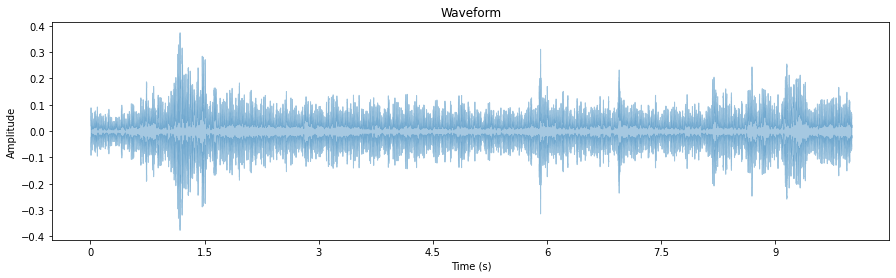

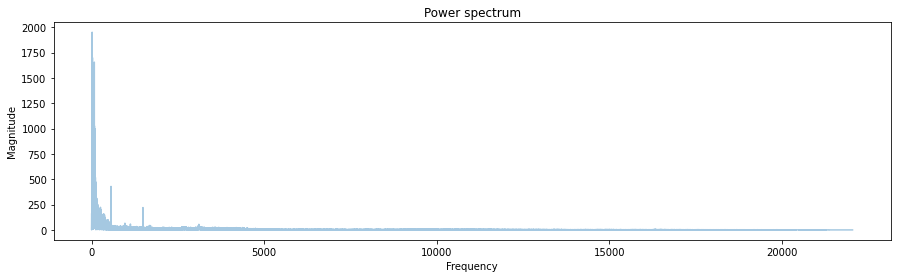

In [ ]:
sample_rate = 44100
draw_signal(train_dataset[3][0].numpy(), sample_rate)

In [ ]:
import tarfile
import argparse

def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        for file in os.listdir(source_dir):
            if file == "data":
                pass
            elif file.split(".")[-1] == "egg-info":
                pass
            else:
                tar.add(os.path.join(source_dir, file))

In [ ]:
batchsize = 64
num_workers = 1
reload = False
dropout = 0.2
specAugment = [128, 2, 32, 2]
lr = 1e-3
eta_min = 1e-5
epoch = 1
weight_decay = 1e-5
mixup_alpha = None
out_dir =  "data/TAU-urban-acoustic-scenes-2020-mobile-development/trained_models/"

In [ ]:
from sp4asc.training import CELoss
from sp4asc.training import MixUp
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

class TrainingManager:
    def __init__(
        self,
        net,
        spectrogram,
        loader_train,
        loader_test,
        optim,
        scheduler,
        max_epoch,
        reload,
        mixup_alpha,
        path_to_ckpt,
        nb_classes=10
    ):

        # Optim. methods
        self.optim = optim
        self.scheduler = scheduler

        # Dataloaders
        self.max_epoch = max_epoch
        self.loader_train = loader_train
        self.loader_test = loader_test

        # Networks
        self.dev = "cuda" if torch.cuda.is_available() else "cpu"
        self.net = net.to(self.dev)
        self.spectrogram = spectrogram.to(self.dev).eval()

        # Mixup and loss
        self.loss = CELoss(nb_classes=nb_classes)
        self.mixup = MixUp(alpha=mixup_alpha, nb_classes=nb_classes)

        # Checkpoints
        self.path_to_ckpt = path_to_ckpt + "/ckpt.pth"
        if reload:
            self.load_state()
        else:
            self.current_epoch = 0

        # Monitoring
        self.writer = SummaryWriter(
            path_to_ckpt + "/tensorboard/",
            purge_step=self.current_epoch + 1,
        )

    def print_log(self, running_loss, nb_it, acc, nb_instances):
        log = (
            "\nEpoch: {0:d} :".format(self.current_epoch)
            + " loss = {0:.3f}".format(running_loss / (nb_it + 1))
            + " - acc1 = {0:.3f}".format(100 * acc / nb_instances)
        )
        print(log)

    def one_epoch(self, training):

        # Train or eval mode
        if training:
            self.net.train()
            self.mixup.train()
            loader = self.loader_train
            print("\nTraining: %d/%d epochs" % (self.current_epoch, self.max_epoch))
        else:
            self.net.eval()
            self.mixup.eval()
            loader = self.loader_test
            print("\nTest:")

        # Stat.
        acc = 0
        nb_instances = 0
        running_loss = 0
        delta = len(loader) // 3

        # Loop over mini-batches
        bar_format = "{desc:<5.5}{percentage:3.0f}%|{bar:50}{r_bar}"
        for it, batch in enumerate(tqdm(loader, bar_format=bar_format)):

            # Data
            sound = batch[0].to(self.dev, non_blocking=True)
            gt_class = batch[1].to(self.dev, non_blocking=True)
           
            # Get network outputs with mixup during training
            with torch.no_grad():
                sound = self.spectrogram(sound)
               
                sound, gt_class = self.mixup(sound, gt_class)
                
                if not training:
                    pred_class = self.net(sound)
            if training:
                self.optim.zero_grad()
                pred_class = self.net(sound)

            # Loss & backprop
            loss_class = self.loss(pred_class, gt_class)
            if training:
                
                loss_class.backward()
                # Freezing Pruned weights by making their gradients Zero
                for name, p in model.named_parameters():
                    if 'weight' in name:
                        tensor = p.data.cpu().numpy()
                        grad_tensor = p.grad.data.cpu().numpy()
                        grad_tensor = np.where(tensor < EPS, 0, grad_tensor)
                        p.grad.data = torch.from_numpy(grad_tensor).to(device)
                
                self.optim.step()

            # Log
            acc += (pred_class.max(1)[1] == gt_class.max(1)[1]).sum()
            nb_instances += gt_class.shape[0]
            running_loss += loss_class.item()
            if it % delta == delta - 1:
                self.print_log(running_loss, it, acc, nb_instances)

        # Print log
        self.print_log(running_loss, it, acc, nb_instances)
        header = "Train" if training else "Test"
        self.writer.add_scalar(
            header + "/loss", running_loss / (it + 1), self.current_epoch + 1
        )
        self.writer.add_scalar(
            header + "/acc", 100 * acc / nb_instances, self.current_epoch + 1
        )
        #add return_loss and acc
        return running_loss,  (100 * acc / nb_instances)

    def load_state(self):
        ckpt = torch.load(self.path_to_ckpt, map_location=torch.device(self.dev))
        self.net.load_state_dict(ckpt["net"])
        self.optim.load_state_dict(ckpt["optim"])
        self.scheduler.load_state_dict(ckpt["scheduler"])
        self.current_epoch = ckpt["epoch"]
        # Check config is the same
        for key in ckpt["config"].keys():
            assert key in self.config.keys()
            if key == "reload":
                pass
            assert (
                self.config[key] == ckpt["config"][key]
            ), "Config file is not compatible with saved one."

    def save_state(self):
        dict_to_save = {
            "epoch": self.current_epoch,
            "net": self.net.state_dict(),
            "optim": self.optim.state_dict(),
            "scheduler": self.scheduler.state_dict(),
            "config": self.config,
        }
        torch.save(dict_to_save, self.path_to_ckpt)

    def train(self):
        for _ in range(self.current_epoch, self.max_epoch):
            self.one_epoch(training=True)
            self.scheduler.step()
            self.one_epoch(training=False)
            self.current_epoch += 1
            #self.save_state()
        print("Finished Training")

    def eval(self):
        self.one_epoch(training=False)


## Lottery ticket hypothesis



In [ ]:
# Function for Initialization
def weight_init(m):
    '''
    Usage:
        model = Model()
        model.apply(weight_init)
    '''
    if isinstance(m, nn.Conv1d):
        nn.init.normal_(m.weight.data)
        if m.bias is not None:
            nn.init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv3d):
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:
           nn.init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose1d):
        nn.init.normal_(m.weight.data)
        if m.bias is not None:
            nn.init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose3d):
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.normal_(m.weight.data, mean=1, std=0.02)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, mean=1, std=0.02)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm3d):
        nn.init.normal_(m.weight.data, mean=1, std=0.02)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data)
        nn.init.normal_(m.bias.data)
    elif isinstance(m, nn.LSTM):
        for param in m.parameters():
            if len(param.shape) >= 2:
                nn.init.orthogonal_(param.data)
            else:
                nn.init.normal_(param.data)
    elif isinstance(m, nn.LSTMCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                nn.init.orthogonal_(param.data)
            else:
                nn.init.normal_(param.data)
    elif isinstance(m, nn.GRU):
        for param in m.parameters():
            if len(param.shape) >= 2:
                nn.init.orthogonal_(param.data)
            else:
                nn.init.normal_(param.data)
    elif isinstance(m, nn.GRUCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                nn.init.orthogonal_(param.data)
            else:
                nn.init.normal_(param.data)


In [ ]:
def original_initialization(mask_temp, initial_state_dict):
    global model
    
    step = 0
    for name, param in model.named_parameters(): 
        if "weight" in name: 
            weight_dev = param.device
            param.data = torch.from_numpy(mask_temp[step] * initial_state_dict[name].cpu().numpy()).to(weight_dev)
            step = step + 1
        if "bias" in name:
            param.data = initial_state_dict[name]
    step = 0

In [ ]:
def print_nonzeros(model):
    nonzero = total = 0
    for name, p in model.named_parameters():
        tensor = p.data.cpu().numpy()
        nz_count = np.count_nonzero(tensor)
        total_params = np.prod(tensor.shape)
        nonzero += nz_count
        total += total_params
        print(f'{name:20} | nonzeros = {nz_count:7} / {total_params:7} ({100 * nz_count / total_params:6.2f}%) | total_pruned = {total_params - nz_count :7} | shape = {tensor.shape}')
    print(f'alive: {nonzero}, pruned : {total - nonzero}, total: {total}, Compression rate : {total/nonzero:10.2f}x  ({100 * (total-nonzero) / total:6.2f}% pruned)')
    return (round((nonzero/total)*100,1))

In [ ]:
def plot_train_test_stats(stats,
                          epoch_num,
                          key1='train',
                          key2='test',
                          key1_label=None,
                          key2_label=None,
                          xlabel=None,
                          ylabel=None,
                          title=None,
                          yscale=None,
                          ylim_bottom=None,
                          ylim_top=None,
                          savefig=None,
                          sns_style='darkgrid'
                          ):

    assert len(stats[key1]) == epoch_num, "len(stats['{}'])({}) != epoch_num({})".format(key1, len(stats[key1]), epoch_num)
    assert len(stats[key2]) == epoch_num, "len(stats['{}'])({}) != epoch_num({})".format(key2, len(stats[key2]), epoch_num)

    plt.clf()
    sns.set_style(sns_style)
    x_ticks = np.arange(epoch_num)

    plt.plot(x_ticks, stats[key1], label=key1_label)
    plt.plot(x_ticks, stats[key2], label=key2_label)

    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)

    if title is not None:
        plt.title(title)

    if yscale is not None:
        plt.yscale(yscale)

    if ylim_bottom is not None:
        plt.ylim(bottom=ylim_bottom)
    if ylim_top is not None:
        plt.ylim(top=ylim_top)

    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, fancybox=True)

    if savefig is not None:
        plt.savefig(savefig, bbox_inches='tight')
    else:
        plt.show()

In [ ]:
# Function to make an empty mask of the same size as the model
def make_mask(model):
    global step
    global mask
    step = 0
    for name, param in model.named_parameters(): 
        if 'weight' in name:
            step = step + 1
    mask = [None]* step 
    step = 0
    for name, param in model.named_parameters(): 
        if 'weight' in name:
            tensor = param.data.cpu().numpy()
            mask[step] = np.ones_like(tensor)
            step = step + 1
    step = 0

In [ ]:
# Prune by Percentile module
def prune_by_percentile(percent, resample=False, reinit=False,**kwargs):
        global step
        global mask
        global model

        # Calculate percentile value
        step = 0
        for name, param in model.named_parameters():

            # We do not prune bias term
            if 'weight' in name:
                tensor = param.data.cpu().numpy()
                alive = tensor[np.nonzero(tensor)] # flattened array of nonzero values
                percentile_value = np.percentile(abs(alive), percent)

                # Convert Tensors to numpy and calculate
                weight_dev = param.device
                new_mask = np.where(abs(tensor) < percentile_value, 0, mask[step])
                
                # Apply new weight and mask
                param.data = torch.from_numpy(tensor * new_mask).to(weight_dev)
                mask[step] = new_mask
                step += 1
        step = 0

In [ ]:
loader_train = DataLoader(
    train_dataset,
    batch_size=batchsize,
    shuffle=True,
    pin_memory=True,
    num_workers=num_workers,
    drop_last=True,
)

loader_test = DataLoader(
    test_dataset,
    batch_size=batchsize,
    shuffle=False,
    pin_memory=True,
    num_workers=num_workers,
    drop_last=True,
)

# --- Get network
spectrogram = LogMelSpectrogram()
model = model_resnet
# Weight Initialization
model.apply(weight_init)

print("\n\nNet at training time")
print(model)

# ---
optim = torch.optim.AdamW(
    [
        {"params": model.parameters()},
    ],
    lr=lr,
    weight_decay=weight_decay
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim,
    epoch,
    eta_min=eta_min
)

# --- Log dir
path2log = out_dir

# --- Training
mng = TrainingManager(
    model,
    spectrogram,
    loader_train,
    loader_test,
    optim,
    scheduler,
    epoch ,
    reload,
    mixup_alpha,
    path2log
)

make_mask(model)
initial_state_dict = copy.deepcopy(model.state_dict())
#mng.train()



Net at training time
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu)

In [ ]:
# Layer Looper
for name, param in model.named_parameters():
    print(name, param.size())

conv1.weight torch.Size([64, 1, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer2.0.conv1.weight torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight torch.Size([128])
layer2.0.bn1.bias torch.Size([128])
layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
layer2.0.bn2.weight torch.Size([128])
layer2.0.bn2.bias torch.Size([128])
layer2.0.downsample.0.weight torch.Size([128, 64, 1, 1])
layer2.0.downsample.1.weight torch.Size([128])
layer2.0.downsample.1.bias torch.Size([128])
layer2.1.conv1.weight tor

In [ ]:
# Pruning
# NOTE First Pruning Iteration is of No Compression
bestacc = 0.0
best_accuracy = 0
ITERATION = 2
comp = np.zeros(ITERATION,float)
bestacc = np.zeros(ITERATION,float)
step = 0
all_loss = np.zeros(epoch,float)
all_accuracy = np.zeros(epoch,float)
prune_percent = 10
resample = False
reinit = False


In [ ]:
for _ite in range(0, ITERATION):

        if not _ite == 0:
            prune_by_percentile(prune_percent, resample=resample, reinit=reinit)
            if reinit:
                model.apply(weight_init)
                for name, param in model.named_parameters():
                    if 'weight' in name:
                        weight_dev = param.device
                        param.data = torch.from_numpy(param.data.cpu().numpy() * mask[step]).to(weight_dev)
                        step = step + 1
                step = 0
            else:
                original_initialization(mask, initial_state_dict)
        # Print the table of Nonzeros in each layer

        comp1 = print_nonzeros(model)
        comp[_ite] = comp1

        pbar = tqdm(range(epoch))
        valid_freq = 2
        print_frequency = 10
        for iter_ in pbar:

          # Training
          loss,accuracy = mng.one_epoch(training=True)
          mng.current_epoch +=1
          all_loss[iter_] = loss
          all_accuracy[iter_] = accuracy
          
            # Frequency for Testing
          if iter_ %valid_freq == 0:
              _,accuracy = mng.one_epoch(training=False)
              # Save Weights
              if accuracy > best_accuracy:
                  best_accuracy = accuracy
                  #utils.checkdir(f"{os.getcwd()}/saves/{args.arch_type}/{args.dataset}/")
                  torch.save(model,f"{os.getcwd()}/saves/{_ite}_model_.pth.tar")
                  
          # Frequency for Printing Accuracy and Loss
          #if iter_ % print_frequency == 0:
          #    pbar.set_description(
            #       f'Train Epoch: {iter_}/{Iteration} Loss: {loss:.6f} Accuracy: {accuracy:.2f}% Best Accuracy: {best_accuracy:.2f}%')       
        print('Accuracy Of the model ', _ite, '=', best_accuracy)
        bestacc[_ite] = best_accuracy

conv1.weight         | nonzeros =    3136 /    3136 (100.00%) | total_pruned =       0 | shape = (64, 1, 7, 7)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
bn1.bias             | nonzeros =       0 /      64 (  0.00%) | total_pruned =      64 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   36864 /   36864 (100.00%) | total_pruned =       0 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.bn1.bias    | nonzeros =       0 /      64 (  0.00%) | total_pruned =      64 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   36864 /   36864 (100.00%) | total_pruned =       0 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.bn2.bias    | nonzeros =       0 /      64 (  0.00%) | total_pruned =      64 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   36864 / 

  0%|          | 0/1 [00:00<?, ?it/s]


Training: 0/1 epochs



      33%|████████████████▌                                 | 36/109 [13:04<25:11, 20.71s/it]


Epoch: 0 : loss = 1.847 - acc1 = 37.023



      66%|█████████████████████████████████                 | 72/109 [24:26<12:51, 20.86s/it]


Epoch: 0 : loss = 1.638 - acc1 = 41.602



      99%|█████████████████████████████████████████████████▌| 108/109 [37:13<00:21, 21.44s/it]


Epoch: 0 : loss = 1.516 - acc1 = 44.835



     100%|██████████████████████████████████████████████████| 109/109 [37:30<00:00, 20.65s/it]



Epoch: 0 : loss = 1.515 - acc1 = 44.882

Test:



      30%|███████████████▏                                  | 7/23 [02:39<06:20, 23.79s/it]


Epoch: 1 : loss = 2.932 - acc1 = 28.125



      61%|██████████████████████████████▍                   | 14/23 [05:30<03:36, 24.07s/it]


Epoch: 1 : loss = 2.572 - acc1 = 35.156



      91%|█████████████████████████████████████████████▋    | 21/23 [07:40<00:43, 21.85s/it]


Epoch: 1 : loss = 2.426 - acc1 = 29.836



     100%|██████████████████████████████████████████████████| 23/23 [08:32<00:00, 22.30s/it]



Epoch: 1 : loss = 2.390 - acc1 = 30.027


100%|██████████| 1/1 [46:03<00:00, 2763.66s/it]


Accuracy Of the model  0 = tensor(30.0272, device='cuda:0')
conv1.weight         | nonzeros =    2822 /    3136 ( 89.99%) | total_pruned =     314 | shape = (64, 1, 7, 7)
bn1.weight           | nonzeros =      57 /      64 ( 89.06%) | total_pruned =       7 | shape = (64,)
bn1.bias             | nonzeros =       0 /      64 (  0.00%) | total_pruned =      64 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   33177 /   36864 ( 90.00%) | total_pruned =    3687 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      57 /      64 ( 89.06%) | total_pruned =       7 | shape = (64,)
layer1.0.bn1.bias    | nonzeros =       0 /      64 (  0.00%) | total_pruned =      64 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   33177 /   36864 ( 90.00%) | total_pruned =    3687 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      57 /      64 ( 89.06%) | total_pruned =       7 | shape = (64,)
layer1.0.bn2.bias    | nonzeros =       0 /      64 (  0.00%) | total_pruned =      64 |

  0%|          | 0/1 [00:00<?, ?it/s]


Training: 1/1 epochs



      33%|████████████████▌                                 | 36/109 [07:39<17:44, 14.58s/it]


Epoch: 1 : loss = 1.725 - acc1 = 37.326



      66%|█████████████████████████████████                 | 72/109 [18:43<12:59, 21.07s/it]


Epoch: 1 : loss = 1.525 - acc1 = 43.490



      99%|█████████████████████████████████████████████████▌| 108/109 [32:29<00:25, 25.11s/it]


Epoch: 1 : loss = 1.418 - acc1 = 47.309



     100%|██████████████████████████████████████████████████| 109/109 [32:56<00:00, 18.14s/it]



Epoch: 1 : loss = 1.415 - acc1 = 47.420

Test:



      30%|███████████████▏                                  | 7/23 [02:48<06:16, 23.53s/it]


Epoch: 2 : loss = 6.779 - acc1 = 1.563



      61%|██████████████████████████████▍                   | 14/23 [05:40<03:32, 23.63s/it]


Epoch: 2 : loss = 5.942 - acc1 = 3.237



      91%|█████████████████████████████████████████████▋    | 21/23 [07:50<00:42, 21.32s/it]


Epoch: 2 : loss = 5.001 - acc1 = 10.268



100%|██████████| 1/1 [41:33<00:00, 2493.19s/it]


Epoch: 2 : loss = 4.655 - acc1 = 13.723
Accuracy Of the model  1 = tensor(30.0272, device='cuda:0')


In [ ]:
loader_train = DataLoader(
    train_dataset,
    batch_size=batchsize,
    shuffle=True,
    pin_memory=True,
    num_workers=num_workers,
    drop_last=True,
)

loader_test = DataLoader(
    test_dataset,
    batch_size=batchsize,
    shuffle=False,
    pin_memory=True,
    num_workers=num_workers,
    drop_last=True,
)
model_resnet_2 = models.resnet18(pretrained=False,progress=True)
model_resnet_2.fc = torch.nn.Linear(in_features=512,out_features=10)
model_resnet_2.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)


# --- Get network
spectrogram = LogMelSpectrogram()
model_2 = model_resnet_2
# Weight Initialization
model_2.apply(weight_init)

print("\n\nNet at training time")
print(model_2)

# ---
optim = torch.optim.AdamW(
    [
        {"params": model_2.parameters()},
    ],
    lr=lr,
    weight_decay=weight_decay
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim,
    epoch,
    eta_min=eta_min
)

# --- Log dir
path2log = out_dir

# --- Training
mng_2 = TrainingManager(
    model_2,
    spectrogram,
    loader_train,
    loader_test,
    optim,
    scheduler,
    epoch ,
    reload,
    mixup_alpha,
    path2log
)

make_mask(model_2)
initial_state_dict = copy.deepcopy(model_2.state_dict())
#mng_2.train()


# Pruning
# NOTE First Pruning Iteration is of No Compression
bestacc = 0.0
best_accuracy = 0
ITERATION = 2
comp = np.zeros(ITERATION,float)
bestacc = np.zeros(ITERATION,float)
step = 0
all_loss = np.zeros(epoch,float)
all_accuracy = np.zeros(epoch,float)
prune_percent = 70
resample = False
reinit = False




Net at training time
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu)

In [ ]:
for _ite in range(0, ITERATION):
        best_accuracy=0
        if not _ite == 0:
            prune_by_percentile(prune_percent, resample=resample, reinit=reinit)
            if reinit:
                model_2.apply(weight_init)
                for name, param in model_2.named_parameters():
                    if 'weight' in name:
                        weight_dev = param.device
                        param.data = torch.from_numpy(param.data.cpu().numpy() * mask[step]).to(weight_dev)
                        step = step + 1
                step = 0
            else:
                original_initialization(mask, initial_state_dict)
                mng_2.current_epoch=0
        # Print the table of Nonzeros in each layer

        comp1 = print_nonzeros(model_2)
        comp[_ite] = comp1

        pbar = tqdm(range(epoch))
        valid_freq = 2
        print_frequency = 10
        for iter_ in pbar:

          # Training
          loss,accuracy = mng_2.one_epoch(training=True)
          mng_2.current_epoch +=1
          all_loss[iter_] = loss
          all_accuracy[iter_] = accuracy
          
            # Frequency for Testing
          if iter_ %valid_freq == 0:
              _,accuracy = mng_2.one_epoch(training=False)
              # Save Weights
              if accuracy > best_accuracy:
                  best_accuracy = accuracy
                  #utils.checkdir(f"{os.getcwd()}/saves/{args.arch_type}/{args.dataset}/")
                  #torch.save(model_2,f"{os.getcwd()}/saves/{_ite}_model_2_prunned.pth.tar")
                  
          # Frequency for Printing Accuracy and Loss
          #if iter_ % print_frequency == 0:
          #    pbar.set_description(
            #       f'Train Epoch: {iter_}/{Iteration} Loss: {loss:.6f} Accuracy: {accuracy:.2f}% Best Accuracy: {best_accuracy:.2f}%')       
        print('Accuracy Of the model_2 ', _ite, '=', best_accuracy)
        bestacc[_ite] = best_accuracy

conv1.weight         | nonzeros =    3136 /    3136 (100.00%) | total_pruned =       0 | shape = (64, 1, 7, 7)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
bn1.bias             | nonzeros =       0 /      64 (  0.00%) | total_pruned =      64 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   36864 /   36864 (100.00%) | total_pruned =       0 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.bn1.bias    | nonzeros =       0 /      64 (  0.00%) | total_pruned =      64 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   36864 /   36864 (100.00%) | total_pruned =       0 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.bn2.bias    | nonzeros =       0 /      64 (  0.00%) | total_pruned =      64 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   36864 / 

  0%|          | 0/1 [00:00<?, ?it/s]


Training: 0/1 epochs



      33%|████████████████▌                                 | 36/109 [07:27<16:27, 13.53s/it]


Epoch: 0 : loss = 2.128 - acc1 = 27.865



      66%|█████████████████████████████████                 | 72/109 [17:35<12:14, 19.86s/it]


Epoch: 0 : loss = 1.858 - acc1 = 35.308



      99%|█████████████████████████████████████████████████▌| 108/109 [32:07<00:23, 23.87s/it]


Epoch: 0 : loss = 1.708 - acc1 = 38.354



     100%|██████████████████████████████████████████████████| 109/109 [32:35<00:00, 17.94s/it]



Epoch: 0 : loss = 1.704 - acc1 = 38.575

Test:



      30%|███████████████▏                                  | 7/23 [02:53<06:40, 25.05s/it]


Epoch: 1 : loss = 2.424 - acc1 = 16.964



      61%|██████████████████████████████▍                   | 14/23 [05:59<03:52, 25.82s/it]


Epoch: 1 : loss = 1.778 - acc1 = 43.415



      91%|█████████████████████████████████████████████▋    | 21/23 [08:26<00:45, 22.73s/it]


Epoch: 1 : loss = 1.974 - acc1 = 30.729



100%|██████████| 1/1 [41:54<00:00, 2514.80s/it]



Epoch: 1 : loss = 2.136 - acc1 = 28.193
Accuracy Of the model_2  0 = tensor(28.1929, device='cuda:0')
conv1.weight         | nonzeros =    3136 /    3136 (100.00%) | total_pruned =       0 | shape = (64, 1, 7, 7)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
bn1.bias             | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   36864 /   36864 (100.00%) | total_pruned =       0 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.bn1.bias    | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   36864 /   36864 (100.00%) | total_pruned =       0 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.bn2.bias    | nonzeros =      64 /  

  0%|          | 0/1 [00:00<?, ?it/s]


Training: 0/1 epochs



  0%|          | 0/1 [05:32<?, ?it/s]


KeyboardInterrupt: ignored